In [2]:
import os
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, EarlyStoppingCallback
import evaluate
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers
import warnings

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [4]:
DATA_PATH = '../../data/processed/'

In [5]:
df_comments = pd.read_csv(os.path.join(DATA_PATH, 'labeled_posts.csv')).rename(columns={'post_id': 'id'})
df_comment = pd.read_csv(os.path.join(DATA_PATH, 'labeled_post.csv')).rename(columns={'post_id': 'id'})

df_all_comments = pd.concat([df_comments, df_comment], ignore_index=True)
df_all_comments = df_all_comments[['id', 'text', 'label']].dropna()
df_all_comments['label'] = df_all_comments['label'].astype(int)


In [6]:
# Stratifizierter Split
trainval_df, test_df = train_test_split(
    df_all_comments,
    test_size=0.2,
    stratify=df_all_comments["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 → 60/20/20 Split
    stratify=trainval_df["label"],
    random_state=42
)

# Indizes zurücksetzen
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("✅ Splits erzeugt:")
print(f"- Train: {len(train_df)}")
print(f"- Val:   {len(val_df)}")
print(f"- Test:  {len(test_df)}")


✅ Splits erzeugt:
- Train: 178
- Val:   60
- Test:  60


In [7]:
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print("Train labels:\n", train_df["label"].value_counts())


Train size: 178
Val size: 60
Test size: 60
Train labels:
 label
1    96
0    57
2    25
Name: count, dtype: int64


## Weighted Loss

In [8]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ **kwargs ergänzt
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [9]:
# 🔢 Manuelle Class Weights – hier z. B. stärkerer Fokus auf bearish
weights_tensor = torch.tensor([1.0, 2.0, 1.0], dtype=torch.float)
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor.to(device))


## Model

In [10]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "finbert_posts": os.path.join(EXPERIMENTS_BASE_PATH, "finbert_posts"),
}

for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS["finbert_posts"])
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS["finbert_posts"], num_labels=3)


In [12]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)


In [13]:
# Tokenisierung
train_ds = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_ds = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Format setzen – Korrekt pro Dataset!
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 60/60 [00:00<00:00, 13335.01 examples/s]


In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }


In [ ]:
results = {}
lrs = [2e-5, 1e-5, 5e-6, 3e-6, 1e-6]

for lr in lrs:
    print(f"Starte Training für learning_rate = {lr}")

    output_dir = os.path.join(MODEL_PATHS["finbert_posts"], f"finetuned_lr_{lr}")
    logging_dir = os.path.join("../../logs/finbert_posts", f"lr_{lr}")
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(logging_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=logging_dir,
        logging_strategy="epoch",
        report_to="none",
        remove_unused_columns=False,
        disable_tqdm=True
    )

    trainer = WeightedLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )



    start = time.time()
    trainer.train()
    end = time.time()

    logs = trainer.state.log_history
    epoch_logs = [log for log in logs if "eval_f1" in log]
    df = pd.DataFrame(epoch_logs)[["epoch", "eval_f1"]]
    df["learning_rate"] = lr

    results[lr] = {"f1_curve": df,"best_f1": df["eval_f1"].max(),"trainer": trainer}
    
    print(f"Training für learning_rate = {lr} abgeschlossen in {end - start:.2f} Sekunden.")

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25456\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Starte Training für learning_rate = 2e-05
{'loss': 2.3274, 'grad_norm': 33.55178451538086, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 1.0499883890151978, 'eval_accuracy': 0.55, 'eval_f1': 0.42542542542542544, 'eval_runtime': 0.5187, 'eval_samples_per_second': 115.679, 'eval_steps_per_second': 15.424, 'epoch': 1.0}
{'loss': 0.6118, 'grad_norm': 47.39173126220703, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 0.8718302249908447, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.5109485873492665, 'eval_runtime': 0.5103, 'eval_samples_per_second': 117.588, 'eval_steps_per_second': 15.678, 'epoch': 2.0}
{'loss': 0.3099, 'grad_norm': 33.65976333618164, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 1.3011723756790161, 'eval_accuracy': 0.6, 'eval_f1': 0.5653479566523044, 'eval_runtime': 0.508, 'eval_samples_per_second': 118.111, 'eval_steps_per_second': 15.748, 'epoch': 3.0}
{'loss': 0.2129, 'grad_norm': 2.865074396133423, 'learning_rate': 1.2e-05, 'ep

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25456\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0614, 'grad_norm': 1.2010161876678467, 'learning_rate': 9e-06, 'epoch': 1.0}
{'eval_loss': 1.4249283075332642, 'eval_accuracy': 0.55, 'eval_f1': 0.5159791898922333, 'eval_runtime': 0.5913, 'eval_samples_per_second': 101.465, 'eval_steps_per_second': 13.529, 'epoch': 1.0}
{'loss': 0.0244, 'grad_norm': 0.015972664579749107, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 1.5157285928726196, 'eval_accuracy': 0.65, 'eval_f1': 0.6119220151828847, 'eval_runtime': 0.5851, 'eval_samples_per_second': 102.555, 'eval_steps_per_second': 13.674, 'epoch': 2.0}
{'loss': 0.0033, 'grad_norm': 0.001369974692352116, 'learning_rate': 7e-06, 'epoch': 3.0}
{'eval_loss': 1.6303457021713257, 'eval_accuracy': 0.5666666666666667, 'eval_f1': 0.49930177349532184, 'eval_runtime': 0.5995, 'eval_samples_per_second': 100.075, 'eval_steps_per_second': 13.343, 'epoch': 3.0}
{'loss': 0.0017, 'grad_norm': 0.059548523277044296, 'learning_rate': 6e-06, 'epoch': 4.0}
{'eval_loss': 1.5637367963

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25456\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.001, 'grad_norm': 0.0611812025308609, 'learning_rate': 4.5e-06, 'epoch': 1.0}
{'eval_loss': 1.580966591835022, 'eval_accuracy': 0.6, 'eval_f1': 0.540220700152207, 'eval_runtime': 0.5889, 'eval_samples_per_second': 101.886, 'eval_steps_per_second': 13.585, 'epoch': 1.0}
{'loss': 0.0005, 'grad_norm': 0.0026108487509191036, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.0}
{'eval_loss': 1.6167340278625488, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.5197368421052632, 'eval_runtime': 0.6002, 'eval_samples_per_second': 99.965, 'eval_steps_per_second': 13.329, 'epoch': 2.0}
{'loss': 0.0009, 'grad_norm': 0.0014695631107315421, 'learning_rate': 3.5e-06, 'epoch': 3.0}
{'eval_loss': 1.5691592693328857, 'eval_accuracy': 0.6166666666666667, 'eval_f1': 0.5481518213186223, 'eval_runtime': 0.6, 'eval_samples_per_second': 100.003, 'eval_steps_per_second': 13.334, 'epoch': 3.0}
{'loss': 0.0004, 'grad_norm': 0.015881016850471497, 'learning_rate': 3e-06, 'epoch': 4.0}
{'eval_loss': 1

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25456\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0, 'grad_norm': 0.0015694290632382035, 'learning_rate': 2.7e-06, 'epoch': 1.0}
{'eval_loss': 1.8365838527679443, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.6067, 'eval_samples_per_second': 98.904, 'eval_steps_per_second': 13.187, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0007092237356118858, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.0}
{'eval_loss': 1.943284511566162, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.6089, 'eval_samples_per_second': 98.542, 'eval_steps_per_second': 13.139, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': 5.1712471758946776e-05, 'learning_rate': 2.1e-06, 'epoch': 3.0}
{'eval_loss': 1.9877948760986328, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.6138, 'eval_samples_per_second': 97.756, 'eval_steps_per_second': 13.034, 'epoch': 3.0}
{'train_runtime': 25.3125, 'train_samples_per_second': 70.321, 'train_steps_per_second': 9.086

c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_25456\3961012866.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


{'loss': 0.0, 'grad_norm': 0.001051245373673737, 'learning_rate': 9e-07, 'epoch': 1.0}
{'eval_loss': 1.899186372756958, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.6194, 'eval_samples_per_second': 96.874, 'eval_steps_per_second': 12.917, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': 0.0005544134182855487, 'learning_rate': 8e-07, 'epoch': 2.0}
{'eval_loss': 1.9184753894805908, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.5748, 'eval_samples_per_second': 104.381, 'eval_steps_per_second': 13.918, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': 6.855963147245347e-05, 'learning_rate': 7e-07, 'epoch': 3.0}
{'eval_loss': 1.9608367681503296, 'eval_accuracy': 0.5833333333333334, 'eval_f1': 0.509957264957265, 'eval_runtime': 0.6089, 'eval_samples_per_second': 98.531, 'eval_steps_per_second': 13.137, 'epoch': 3.0}
{'train_runtime': 24.0725, 'train_samples_per_second': 73.943, 'train_steps_per_second': 9.554, 'train_loss': 1.6530

C:\Users\hp\AppData\Local\Temp\ipykernel_25456\239583412.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


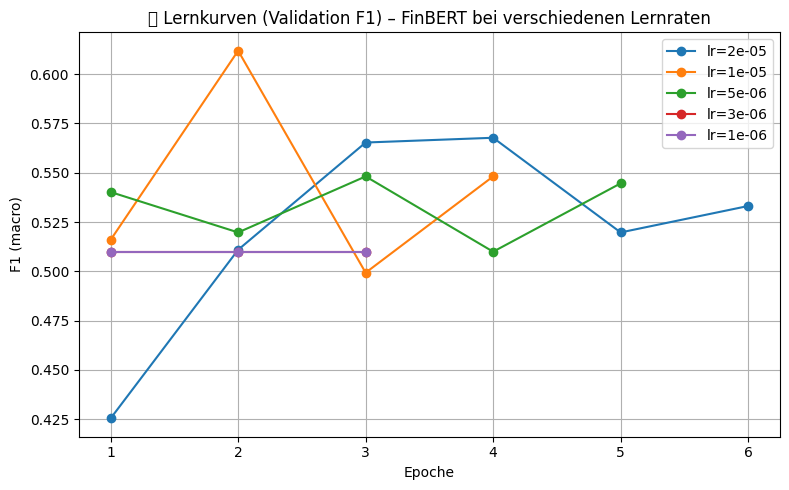

In [16]:
plt.figure(figsize=(8, 5))

for lr, data in results.items():
    df = data["f1_curve"]
    plt.plot(df["epoch"], df["eval_f1"], marker="o", label=f"lr={lr}")

plt.title("📈 Lernkurven (Validation F1) – FinBERT bei verschiedenen Lernraten")
plt.xlabel("Epoche")
plt.ylabel("F1 (macro)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
for lr, res in results.items():
    print(f"lr={lr}: best_f1={res['best_f1']:.4f}")


lr=2e-05: best_f1=0.5678
lr=1e-05: best_f1=0.6119
lr=5e-06: best_f1=0.5482
lr=3e-06: best_f1=0.5100
lr=1e-06: best_f1=0.5100


In [18]:
# Beste Lernrate bestimmen
best_lr = max(results.items(), key=lambda x: x[1]["best_f1"])[0]
best_trainer = results[best_lr]["trainer"]

print(f"\n🏆 Beste Lernrate: {best_lr} mit F1 = {results[best_lr]['best_f1']:.4f}")



🏆 Beste Lernrate: 1e-05 mit F1 = 0.6119


In [19]:
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

# Vorhersage
test_results = best_trainer.predict(test_ds)

# Argmax → Vorhersageklassen
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_results.label_ids

# KEIN Label-Mapping notwendig bei FinBERT

# Hauptmetriken berechnen
f1_macro = f1_score(y_true, y_pred, average="macro")
kappa = cohen_kappa_score(y_true, y_pred)

# Ausgabe
print("\nEvaluation auf Testset:")
print("F1-Score (macro):", round(f1_macro, 4))
print("Cohen’s Kappa:   ", round(kappa, 4))
print("\nKlassifikationsreport:")
print(classification_report(y_true, y_pred))



Evaluation auf Testset:
F1-Score (macro): 0.6997
Cohen’s Kappa:    0.507

Klassifikationsreport:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        19
           1       0.74      0.79      0.76        33
           2       0.67      0.75      0.71         8

    accuracy                           0.72        60
   macro avg       0.70      0.71      0.70        60
weighted avg       0.72      0.72      0.71        60



In [20]:
wrong = [(i, p, t) for i, (p, t) in enumerate(zip(y_pred, y_true)) if p != t]
wrong_df = test_df.iloc[[i for i, _, _ in wrong]].copy()
wrong_df["predicted"] = [p for _, p, _ in wrong]
wrong_df["true"] = [t for _, _, t in wrong]

wrong_df[["text", "true", "predicted"]].head(10)


,text,true,predicted
0,Crypto industry blasts SEC Chair Gensler's con...,1,2
1,"With AI here, the 4 year cycle will become obs...",0,2
9,Solid alt coins to get? I am an eth holder but...,0,1
15,Convince me to keep ETH. Maybe my worst and be...,2,1
17,The journey of ETH holder,1,0
18,Crypto boss eats banana art he bought for $8.3m,1,0
19,IF Hyperliquid gets hacked/exploited can funds...,2,1
25,NEW ATH TODAY! https://preview.redd.it/j88qzbb...,0,1
26,Diving into the Liquidity Pool: Week 40 **Curr...,1,0
28,Favourite ALTS for 2025? There's been much tal...,0,1
